In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
from datetime import date, datetime
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#confirm this works
from scipy.special import inv_boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

In [2]:
lmp_data = pd.read_csv('data/processed/price_data.csv')
lmp_data['datetime_beginning_utc'] = pd.to_datetime(lmp_data['datetime_beginning_utc'])
lmp_data['datetime_beginning_ept'] = pd.to_datetime(lmp_data['datetime_beginning_ept'])

In [3]:
mw_data = pd.read_csv('data/processed/mw_data.csv')
mw_data['datetime_beginning_utc'] = pd.to_datetime(mw_data['datetime_beginning_utc'])
mw_data['datetime_beginning_ept'] = pd.to_datetime(mw_data['datetime_beginning_ept'])

In [4]:
lmp_data.head()

datetime_beginning_utc datetime_beginning_ept  total_lmp_rt  \
0    2015-05-27 00:00:00    2015-05-26 20:00:00     34.672699   
1    2015-05-27 01:00:00    2015-05-26 21:00:00     31.089979   
2    2015-05-27 02:00:00    2015-05-26 22:00:00     26.524577   
3    2015-05-27 03:00:00    2015-05-26 23:00:00     23.878195   
4    2015-05-27 04:00:00    2015-05-27 00:00:00     20.678953   

   system_energy_price_rt  congestion_price_rt  marginal_loss_price_rt  \
0                   33.97            -0.270768                0.973467   
1                   30.10             0.186503                0.803476   
2                   25.63             0.206474                0.688102   
3                   23.16             0.040000                0.678195   
4                   20.10             0.030000                0.548953   

   total_lmp_da  system_energy_price_da  congestion_price_da  \
0     46.914941                   43.41             2.285645   
1     41.301906                   38.70             1.672998   
2     29.224701                   27.10             1.680158   
3     26.698681                   25.47             0.763845   
4     23.586738                   22.81             0.321580   

   marginal_loss_price_da  pepco_mw  bcpep_flow_mw  bcpep_spread_mw  \
0                1.219296  4594.843           4725              875   
1                0.928908  4385.802           4646              954   
2                0.444543  4010.564           4158             1442   
3                0.464836  3614.615           3266             1734   
4                0.455158  3295.574           3276             3024   

   maintenance_outages_mw  forced_outages_mw  dewPoint   enthalpy  \
0                  3336.0             1838.0     67.54  35.360050   
1                  3336.0             1838.0     67.46  34.795831   
2                  3336.0             1838.0     67.51  34.444546   
3                  3336.0             1838.0     67.36  34.086638   
4                  3336.0             1838.0     67.09  33.608461   

   apparentTemperature    DD   CDD  HDD  uvIndex  peak_hour  
0                84.40  0.81  0.81  0.0      0.0          1  
1                81.95  0.71  0.71  0.0      0.0          1  
2                78.88  0.58  0.58  0.0      0.0          1  
3                77.76  0.53  0.53  0.0      0.0          0  
4                76.41  0.48  0.48  0.0      0.0          0

In [5]:
lmp_data.loc[lmp_data['datetime_beginning_ept'] < pd.to_datetime('2019-01-01 00:00:00')].shape

(31565, 23)

In [6]:
mw_data.loc[mw_data['datetime_beginning_ept'] < pd.to_datetime('2019-01-01 00:00:00')].shape

(31565, 15)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def print_metrics(y_true, y_pred):
    """
    prints mean squared error, mean absolute error and mean absolute percentage error
    """
    print('MSE: ', round(mean_squared_error(y_true, y_pred),2))
    print('MAE: ', round(mean_absolute_error(y_true, y_pred),2))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true, y_pred),2),'%')  

In [9]:
def init_prophet_model(regressors=[], holidays=False):
    """
    initializes a prophet model.
    adds regressors from a list of column names to be used as regressors.
    includes holidays if holidays=True
    """
    m = Prophet()
    if len(regressors) > 0:
        for reg in regressors:
            m.add_regressor(reg)
    if holidays == True:
        m.add_country_holidays(country_name='US')
    return m

In [10]:
def prophet_df(df, time, target, regressors):
    """
    prepares dataframe for use with prophet based on
    specified time series, target and regressors
    """
    df_prep = df.copy()
    df_prep.rename(columns={time: 'ds', target: 'y'}, inplace=True)
    df_prep = df_prep[['ds', 'y']+regressors]
    return df_prep

In [40]:
# creating list of all possible regressors for use as baseline model
lmp_base_reg = list(lmp_data.iloc[:,6:].columns)

In [41]:
# initializing baseline model
m_lmp_base = init_prophet_model(lmp_base_reg)

In [42]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_base = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', lmp_base_reg)
pred_lmp_base = df_lmp_base.drop(columns=['y']).copy()

In [ ]:
df_lmp_base

In [43]:
# fitting the baseline model
m_lmp_base.fit(df_lmp_base);

In [44]:
fcst_lmp_base = m_lmp_base.predict(pred_lmp_base)

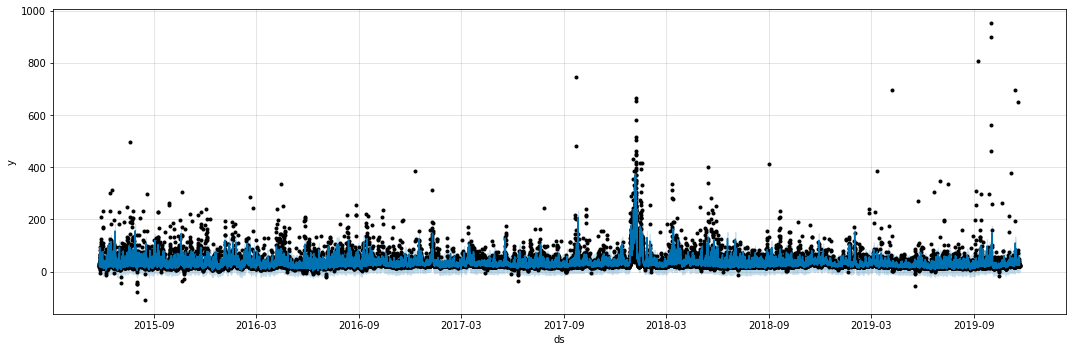

In [45]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp_base.plot(fcst_lmp_base, ax=ax)

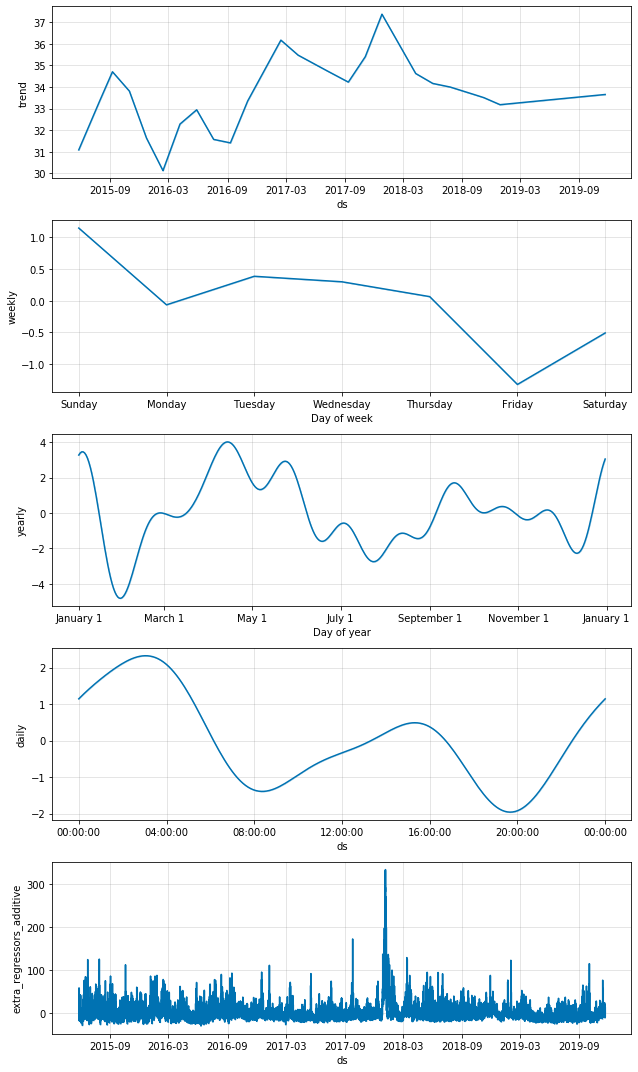

In [46]:
fig = m_lmp_base.plot_components(fcst_lmp_base)

In [47]:
compare_lmp_base = fcst_lmp_base.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_lmp_base.set_index('ds'))

In [48]:
print_metrics(compare_lmp_base['y'], compare_lmp_base['yhat'])

MSE:  442.71
MAE:  7.96
MAPE:  21.86 %


In [ ]:
lmp_base_cv = cross_validation(m_lmp_base, initial='31565 hours', period='2 hours', horizon = '4 hours')

INFO:fbprophet:Making 3886 forecasts with cutoffs between 2019-01-01 01:00:00 and 2019-11-20 19:00:00


In [ ]:
lmp_base_p = performance_metrics(lmp_base_cv)
lmp_base_p.head()

In [ ]:
fig = plot_cross_validation_metric(lmp_base_cv, metric='mape')

In [ ]:
# with scaling

In [40]:
# creating list of all possible regressors for use as baseline model
lmp_base_reg = list(lmp_data.iloc[:,6:].columns)

In [41]:
# initializing baseline model
m_lmp_std = init_prophet_model(lmp_base_reg)

In [42]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_std = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', lmp_base_reg)
pred_lmp_std = df_lmp_std.drop(columns=['y']).copy()

In [ ]:
# scaling the regressors
std_scaler_lmp = StandardScaler()
std_reg_lmp = std_scaler_lmp.fit_transform(df_lmp_std[lmp_base_reg])
df_lmp_std[lmp_base_reg] = std_reg_lmp

In [ ]:
df_lmp_std

In [43]:
# fitting the baseline model
m_lmp_std.fit(df_lmp_std);

In [44]:
fcst_lmp_std = m_lmp_std.predict(pred_lmp_std)

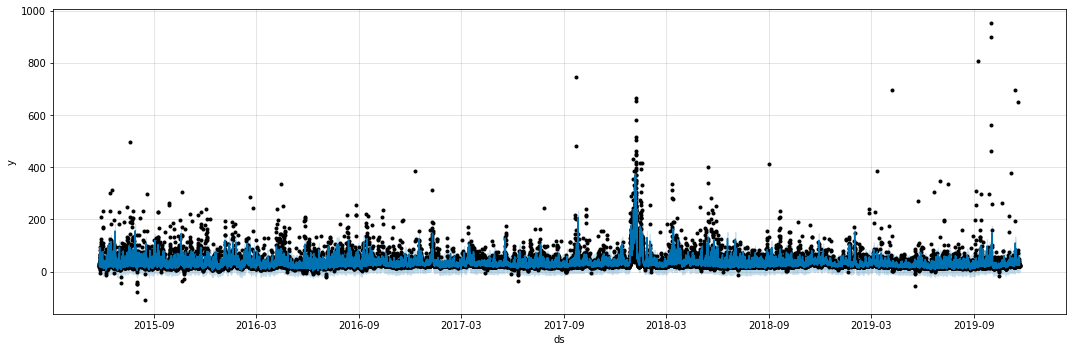

In [45]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp_std.plot(fcst_lmp_std, ax=ax)

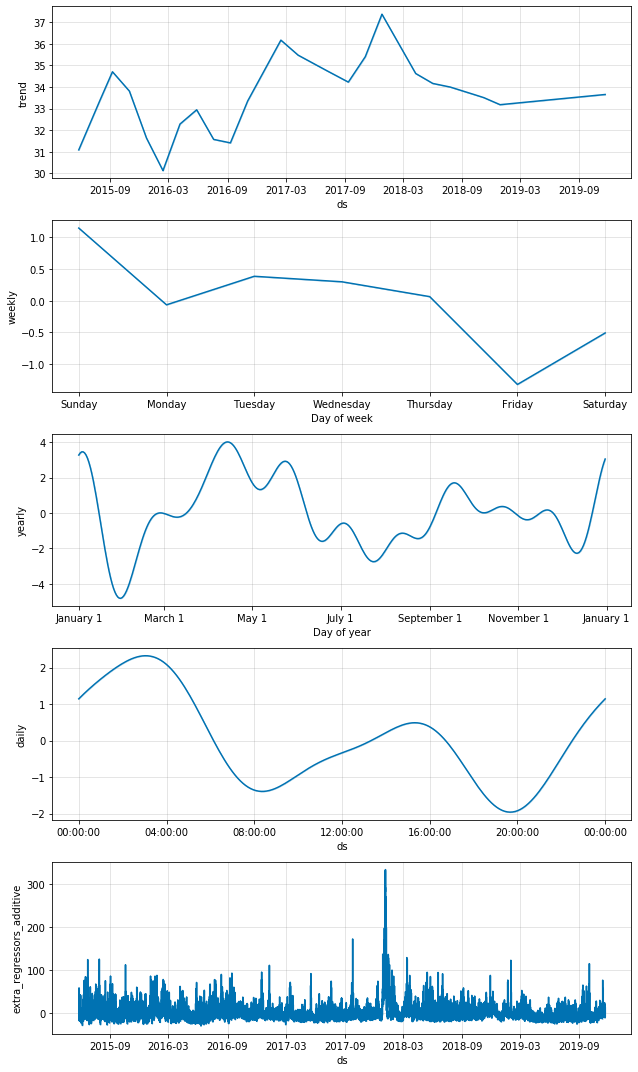

In [46]:
fig = m_lmp_std.plot_components(fcst_lmp_std)

In [47]:
compare_lmp_std = fcst_lmp_std.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_lmp_std.set_index('ds'))

In [48]:
print_metrics(compare_lmp_std['y'], compare_lmp_std['yhat'])

MSE:  442.71
MAE:  7.96
MAPE:  21.86 %


In [ ]:
# with transformations too

In [40]:
# creating list of all possible regressors for use as baseline model
lmp_base_reg = list(lmp_data.iloc[:,6:].columns)

In [41]:
# initializing baseline model
m_lmp_trans = init_prophet_model(lmp_base_reg)

In [42]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_trans = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', lmp_base_reg)
pred_lmp_trans = df_lmp_trans.drop(columns=['y']).copy()

In [ ]:
# scaling the regressors
std_scaler_lmp_trans = StandardScaler()
std_reg_lmp_trans = std_scaler_lmp_trans.fit_transform(df_lmp_trans[lmp_base_reg])
df_lmp_trans[lmp_base_reg] = std_reg_lmp_trans

In [ ]:
yj_lmp = PowerTransformer(method='yeo-johnson')

orig_lmp_y = df_lmp_trans['y'].copy
pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
df_lmp_trans['y'] = transformed_y

In [43]:
# fitting the baseline model
m_lmp_trans.fit(df_lmp_trans);

In [44]:
fcst_lmp_trans = m_lmp_trans.predict(pred_lmp_trans)

In [ ]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_trans[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_trans[column]).reshape(-1, 1))
m_lmp_trans.history['y'] = yj_lmp.inverse_transform(np.array(m_lmp_trans.history['y']).reshape(-1, 1))

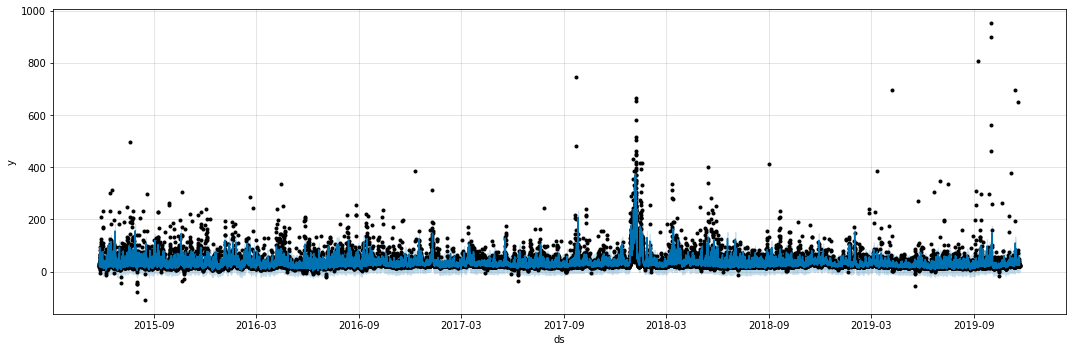

In [45]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp_trans.plot(fcst_lmp_trans, ax=ax)

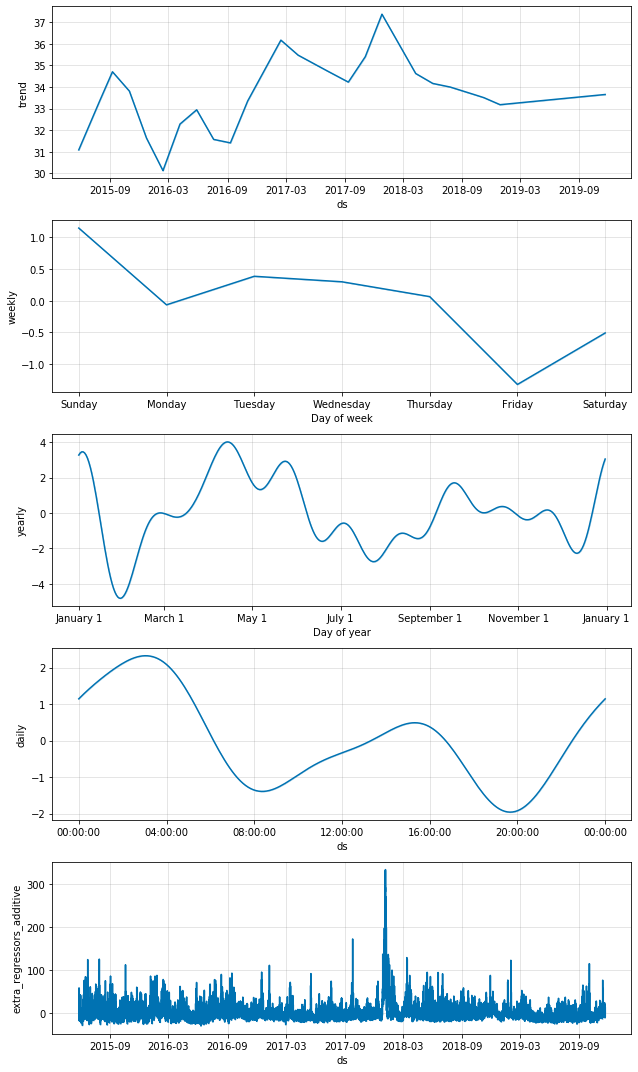

In [46]:
fig = m_lmp_trans.plot_components(fcst_lmp_trans)

In [47]:
compare_lmp_trans = fcst_lmp_trans.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_lmp_trans.set_index('ds'))

In [48]:
print_metrics(compare_lmp_trans['y'], compare_lmp_trans['yhat'])

MSE:  442.71
MAE:  7.96
MAPE:  21.86 %


In [ ]:
# with regressors

In [102]:
df = data[['datetime_beginning_utc', 'total_lmp_rt', 'system_energy_price_da',
           'congestion_price_da', 'marginal_loss_price_da',
           'pepco_mw', 'HDD', 'CDD', 'bcpep_spread_mw',
           'forced_outages_mw']].copy()
df.rename(columns={'datetime_beginning_utc': 'ds', 'total_lmp_rt': 'y'}, inplace=True)

In [103]:
holidays = pd.DataFrame(columns=['ds', 'holiday'])
m_rt = Prophet(holidays=holidays)
m_rt.add_regressor('system_energy_price_da')
m_rt.add_regressor('congestion_price_da')
m_rt.add_regressor('marginal_loss_price_da')
m_rt.add_regressor('pepco_mw')
m_rt.add_regressor('HDD')
m_rt.add_regressor('CDD')
m_rt.add_regressor('bcpep_spread_mw')
m_rt.add_regressor('forced_outages_mw')
m_rt.add_country_holidays(country_name='US')

In [104]:
rt_df = df.copy()

In [105]:
# 7-day prediction size (24 * 7 = 168)
prediction_size = 168
train_df_rt = rt_df[:-prediction_size]

In [106]:
m_rt.fit(train_df_rt);

In [107]:
future_rt = rt_df.drop(columns=['y'])

In [108]:
forecast_rt = m_rt.predict(future_rt)

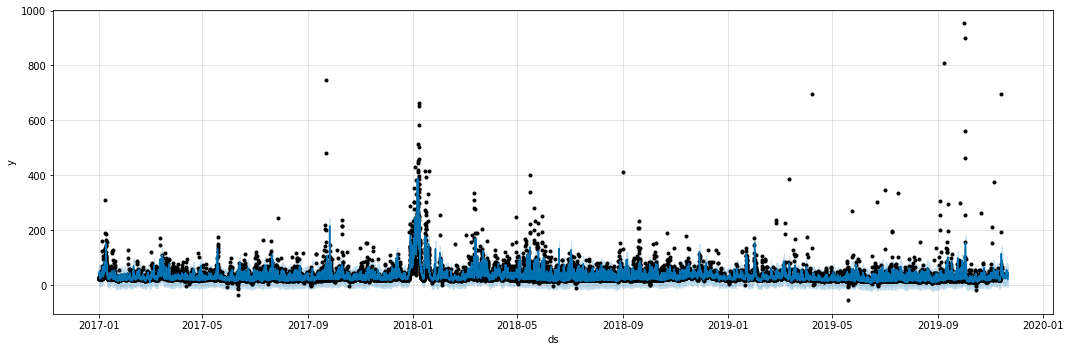

In [109]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_rt.plot(forecast_rt, ax=ax)

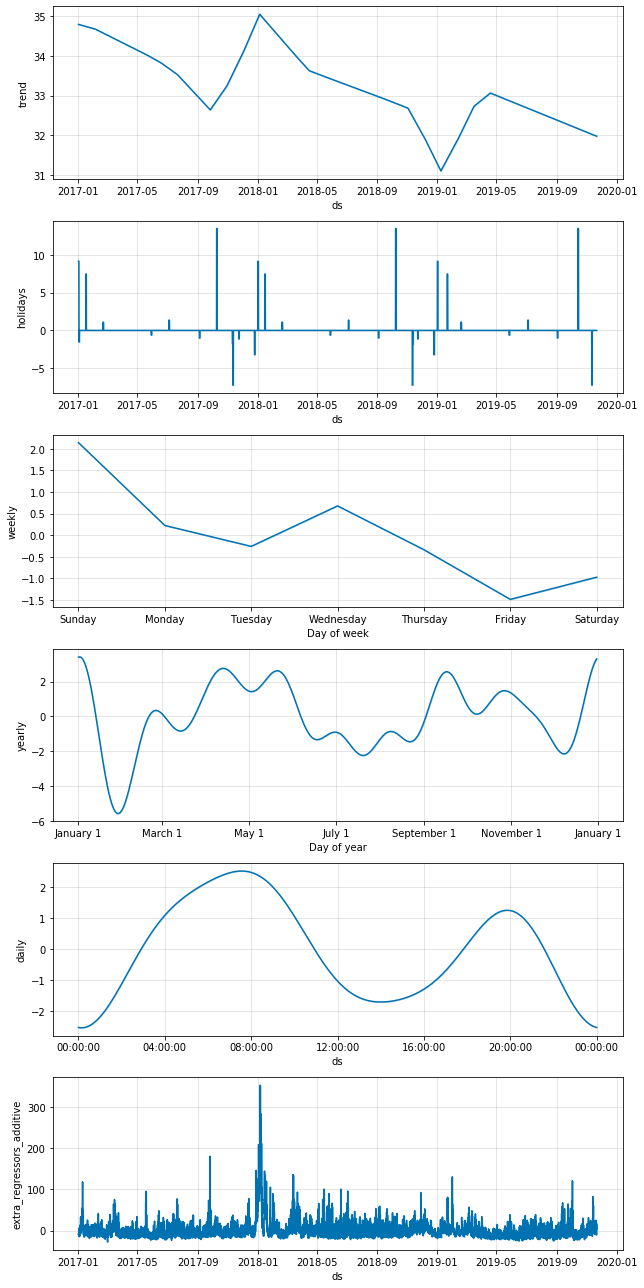

In [110]:
fig = m_rt.plot_components(forecast_rt)

In [111]:
compare_df_rt = forecast_rt.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(rt_df.set_index('ds'))

In [112]:
mean_squared_error(y_true=compare_df_rt['y'],
                   y_pred=compare_df_rt['yhat'])

486.30842966675726

In [113]:
mean_absolute_error(y_true=compare_df_rt['y'],
                   y_pred=compare_df_rt['yhat'])

7.6801146388452235

In [114]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=compare_df_rt['y'],
                   y_pred=compare_df_rt['yhat'])

21.194584712635645

In [ ]:
# transform & rt

In [82]:
df_rt = data[['datetime_beginning_ept', 'total_lmp_rt', 'system_energy_price_da',
           'congestion_price_da', 'marginal_loss_price_da',
           'pepco_mw', 'HDD', 'CDD', 'bcpep_spread_mw',
           'forced_outages_mw']].copy()
df_rt.rename(columns={'datetime_beginning_ept': 'ds', 'total_lmp_rt': 'y'}, inplace=True)

In [83]:
holidays = pd.DataFrame(columns=['ds', 'holiday'])
m_rt_box = Prophet(holidays=holidays)
m_rt_box.add_regressor('system_energy_price_da')
m_rt_box.add_regressor('congestion_price_da')
m_rt_box.add_regressor('marginal_loss_price_da')
m_rt_box.add_regressor('pepco_mw')
m_rt_box.add_regressor('HDD')
m_rt_box.add_regressor('CDD')
m_rt_box.add_regressor('bcpep_spread_mw')
m_rt_box.add_regressor('forced_outages_mw')
m_rt_box.add_country_holidays(country_name='US')

In [84]:
df_rt_box = df_rt.copy()

In [85]:
yj = PowerTransformer(method='yeo-johnson')

In [86]:
pre_y = np.array(df_rt_box['y']).reshape(-1, 1)
transformed_y = yj.fit_transform(pre_y)

In [87]:
df_rt_box['y'] = transformed_y

In [88]:
test = df_rt_box['y'].copy()
test_pre = yj.inverse_transform(np.array(test).reshape(-1, 1))

In [89]:
# 7-day prediction size (24 * 7 = 168)
prediction_size = 168
train_df_rt_box = df_rt_box[:-prediction_size]

In [90]:
m_rt_box.fit(train_df_rt_box);

In [91]:
future_rt_box = df_rt_box.drop(columns=['y'])

In [93]:
forecast_rt_box = m_rt_box.predict(future_rt_box)

In [94]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        forecast_rt_box[column] = yj.inverse_transform(np.array(forecast_rt_box[column]).reshape(-1, 1))
m_rt_box.history['y'] = yj.inverse_transform(np.array(m_rt_box.history['y']).reshape(-1, 1))

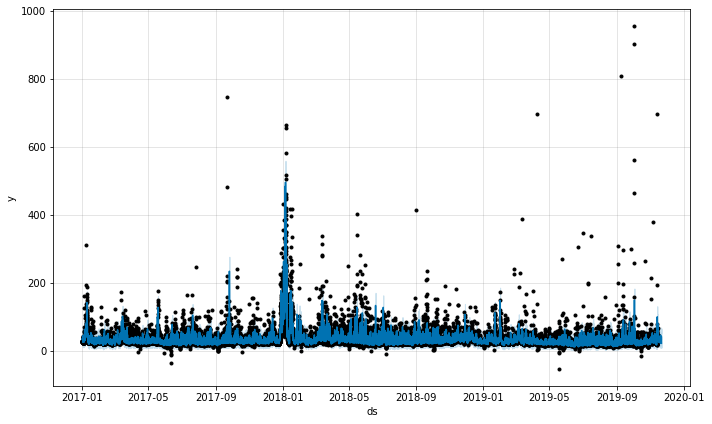

In [95]:
m_rt_box.plot(forecast_rt_box);

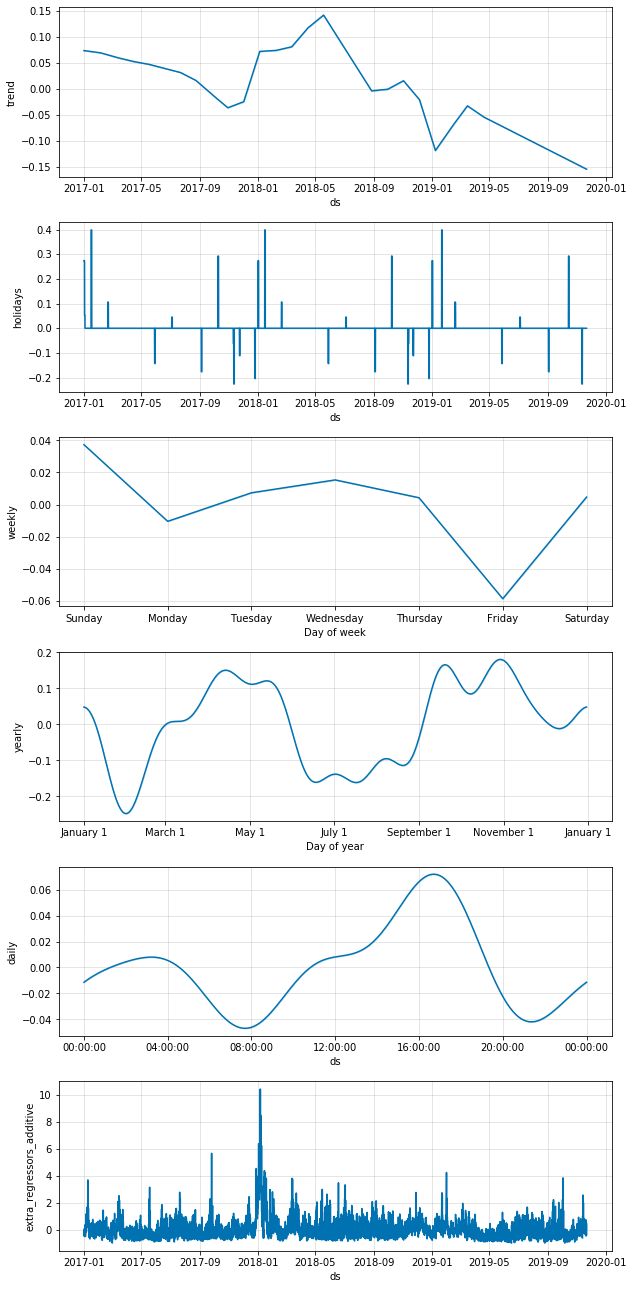

In [96]:
m_rt_box.plot_components(forecast_rt_box);

In [97]:
compare_df_rt_box = forecast_rt_box.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_rt.set_index('ds'))

In [98]:
mean_squared_error(y_true=compare_df_rt_box['y'],
                   y_pred=compare_df_rt_box['yhat'])

497.6157797946192

In [99]:
mean_absolute_error(y_true=compare_df_rt_box['y'],
                   y_pred=compare_df_rt_box['yhat'])

7.078758526418025

In [100]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=compare_df_rt_box['y'],
                   y_pred=compare_df_rt_box['yhat'])

18.453362499736446

In [ ]:
# pepco MW with regressors

In [182]:
df_mw = data[['datetime_beginning_ept', 'pepco_mw', 
              'HDD', 'CDD', 'dewPoint', 'sunniness',
              'total_outages_mw']].copy()
df_mw.rename(columns={'datetime_beginning_ept': 'ds', 'pepco_mw': 'y'}, inplace=True)

In [149]:
df_mw_train = df_mw.loc[df['ds'] < datetime(2019, 6, 1)]
df_mw_test = df_mw.loc[(df['ds'] >= datetime(2019, 6, 1)) & (df_mw['ds'] < datetime(2019, 6, 8))]

In [150]:
holidays = pd.DataFrame(columns=['ds', 'holiday'])
m = Prophet(holidays=holidays)
m.add_regressor('HDD')
m.add_regressor('CDD')
m.add_regressor('dewPoint')
m.add_regressor('sunniness')
m.add_regressor('total_outages_mw')
m.add_country_holidays(country_name='US')

In [151]:
m.fit(df_mw_train)

In [152]:
fcst = m.predict(df_mw_test.reset_index())

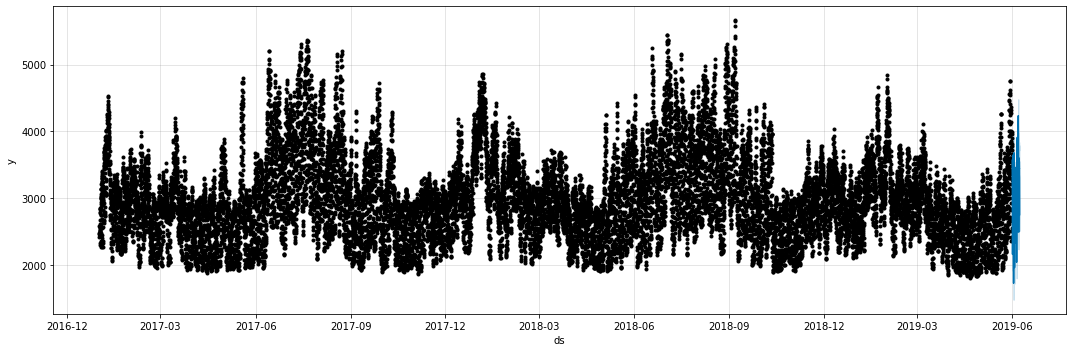

In [153]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m.plot(fcst, ax=ax)

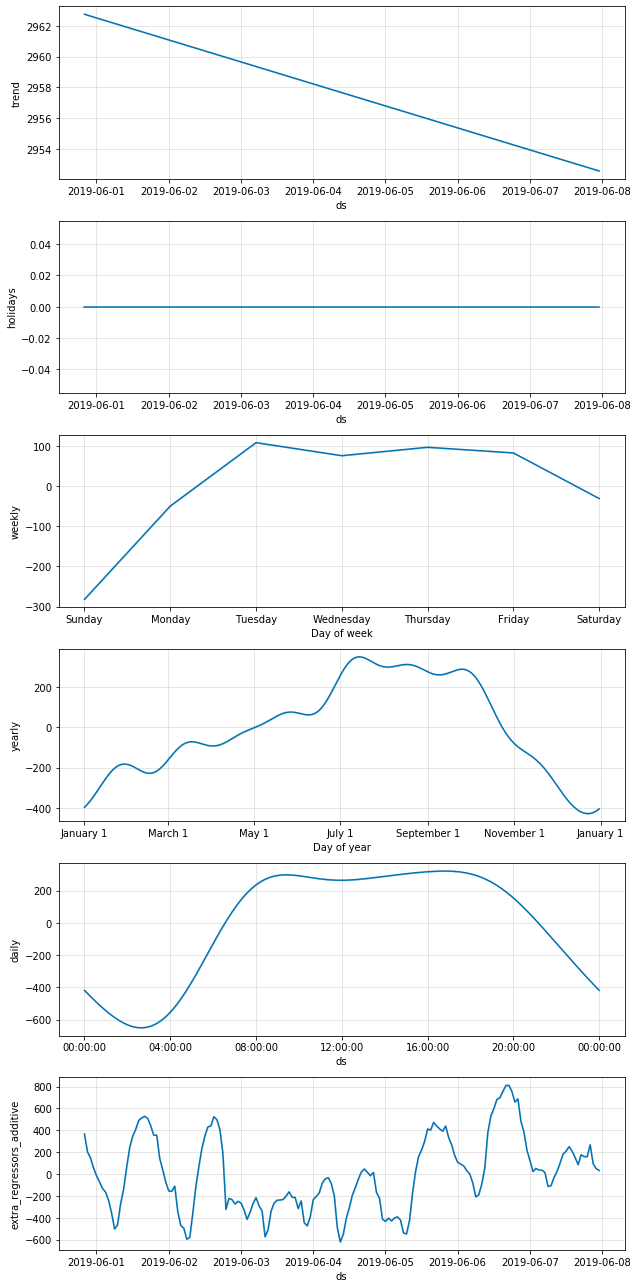

In [154]:
fig = m.plot_components(fcst)

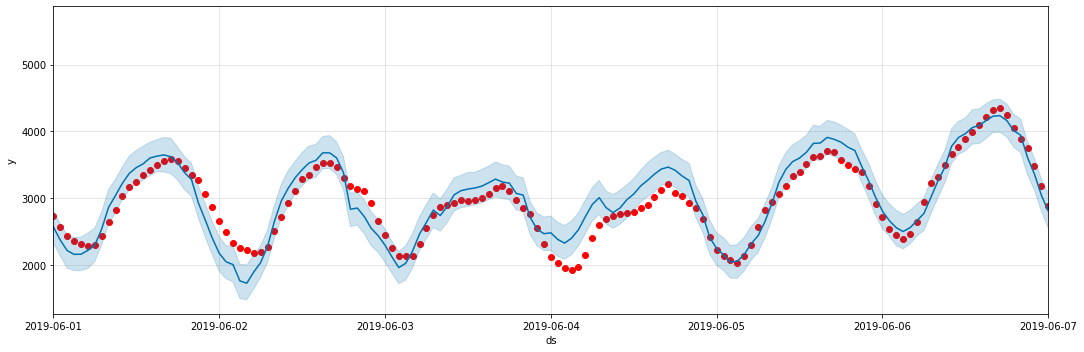

In [158]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_mw_test['ds'], df_mw_test['y'], color='r')
fig = m.plot(fcst, ax=ax)
ax.set_xbound(lower=datetime(2019, 6, 1), upper=datetime(2019, 6, 7))
# ax.set_ylim(0, 60000)
# plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [159]:
mean_squared_error(y_true=df_mw_test['y'],
                   y_pred=fcst['yhat'])

42821.055760666255

In [160]:
mean_absolute_error(y_true=df_mw_test['y'],
                   y_pred=fcst['yhat'])

166.9821650207803

In [161]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_mw_test['y'],
                   y_pred=fcst['yhat'])

5.969288694428922

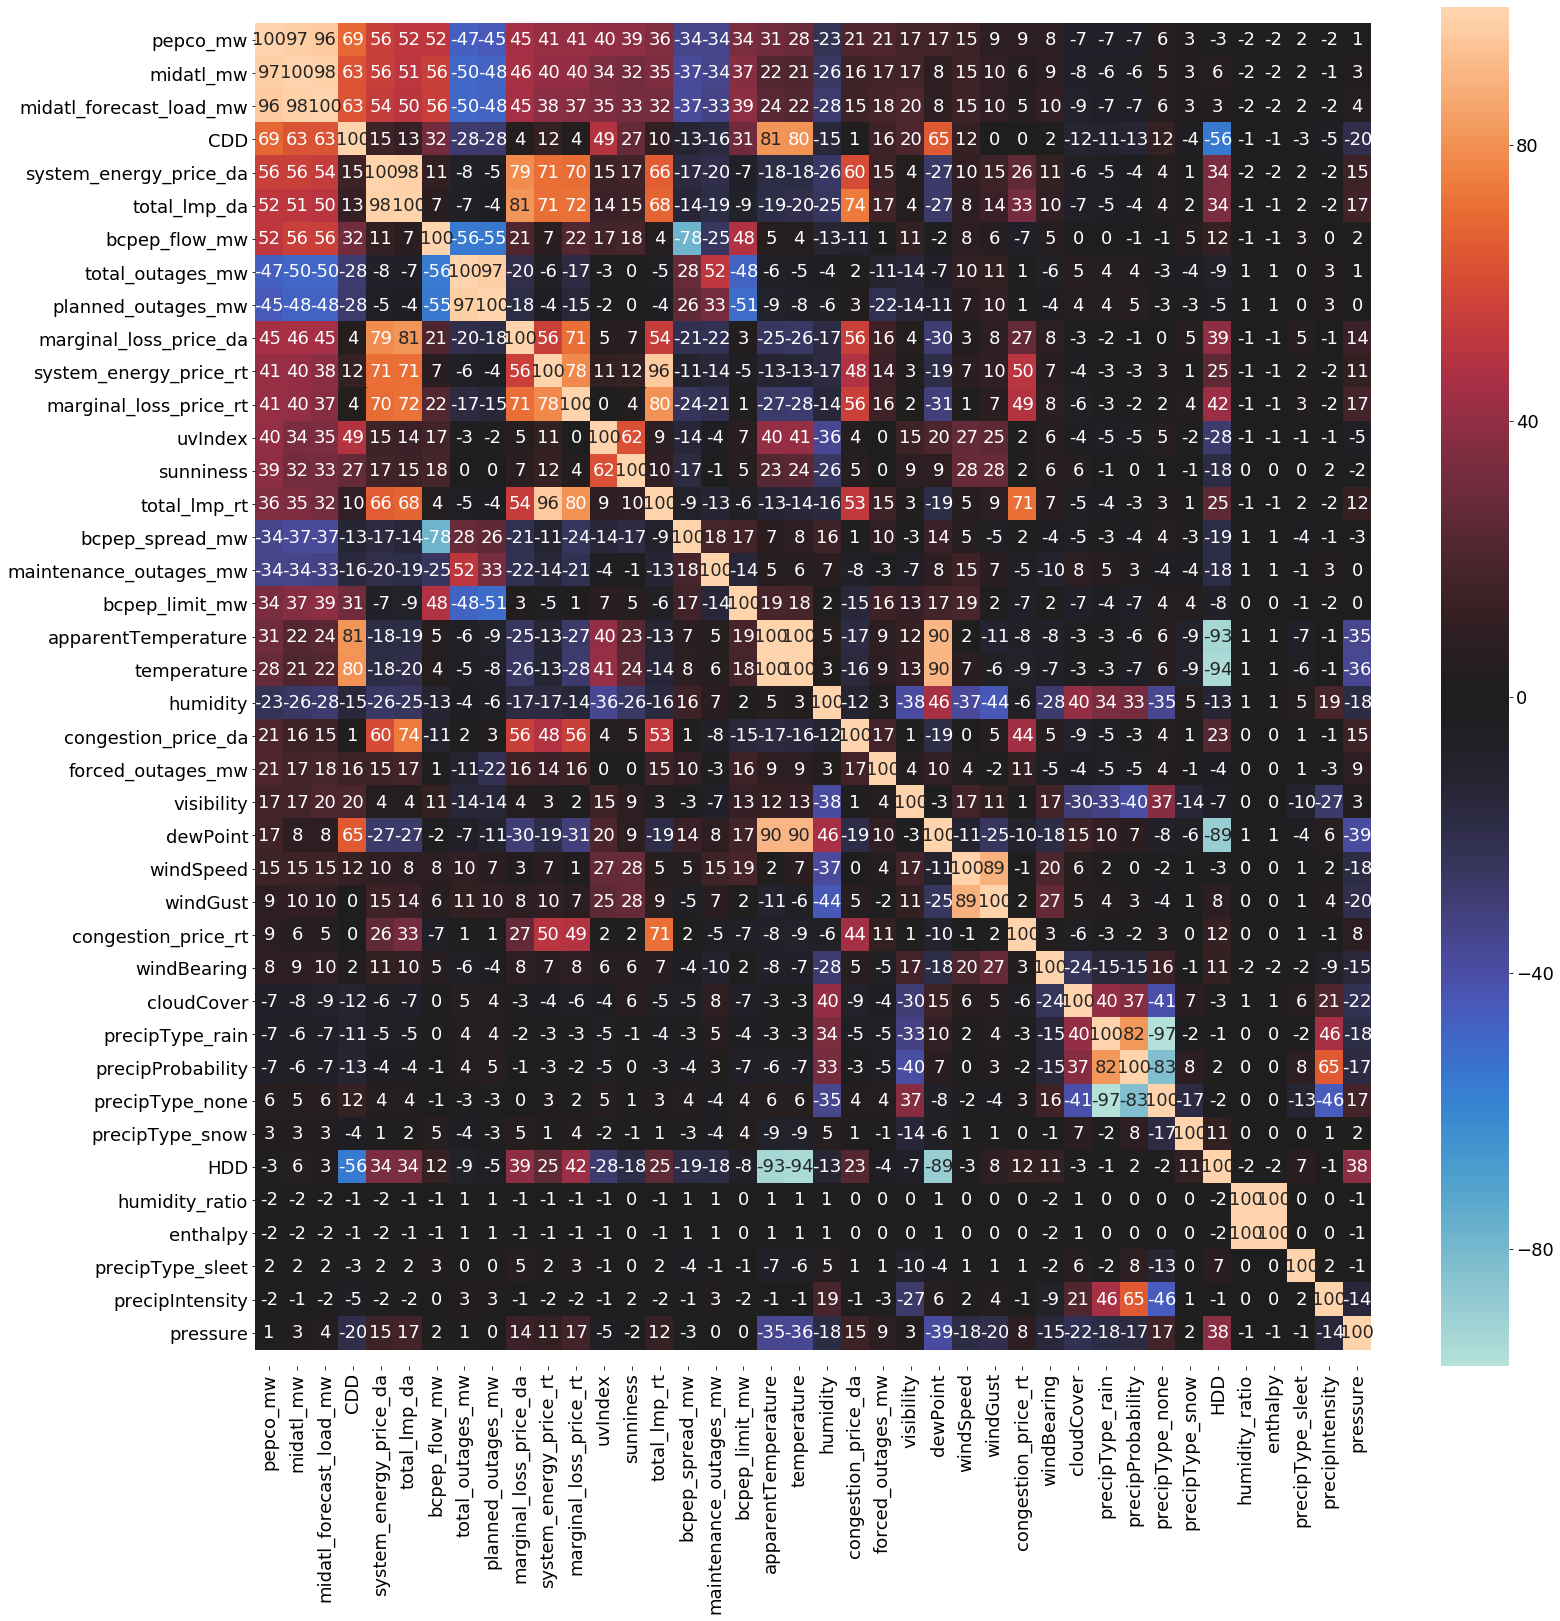

In [204]:
# observing data correlations
#removing time columns
corr_data = data.drop(columns=['datetime_beginning_utc', 'datetime_beginning_ept'])

# creating the sort order
sorted_corr_series = corr_data.corr().pepco_mw.abs().sort_values(ascending=False)
sorted_cols = list(sorted_corr_series.index)

# to allow for larger font sizes,
# the correlations are being rounded and multiplied by 100
sorted_corr_df = corr_data[sorted_cols].corr().round(2)*100

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(sorted_corr_df.astype(int),
           center = 0, annot = True, fmt="d")

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
ax.set_ylim(len(corr_data.columns)+0.5, -0.5);

In [218]:
plt.rcParams.update({'font.size': 10})

In [13]:
df_mw = data[['datetime_beginning_ept', 'pepco_mw', 
              'HDD', 'CDD', 'dewPoint', 'sunniness',
              'total_outages_mw', 'visibility',
              'apparentTemperature']].copy()
df_mw.rename(columns={'datetime_beginning_ept': 'ds', 'pepco_mw': 'y'}, inplace=True)

In [206]:
# 7-day prediction size (24 * 7 = 168)
prediction_size = 168
train_df = df_mw[:-prediction_size]

In [207]:
holidays = pd.DataFrame(columns=['ds', 'holiday'])
m = Prophet(holidays=holidays)
m.add_regressor('HDD')
m.add_regressor('CDD')
m.add_regressor('dewPoint')
m.add_regressor('sunniness')
m.add_regressor('total_outages_mw')
m.add_regressor('visibility')
m.add_regressor('apparentTemperature')
m.add_country_holidays(country_name='US')

In [208]:
m.fit(train_df)

In [209]:
# future = m.make_future_dataframe(periods=prediction_size)
# future = future.loc[future['ds'] < datetime(2019, 11, 14)]
# future.tail(20)

In [210]:
future = df_mw.drop(columns=['y'])

In [211]:
forecast = m.predict(future)

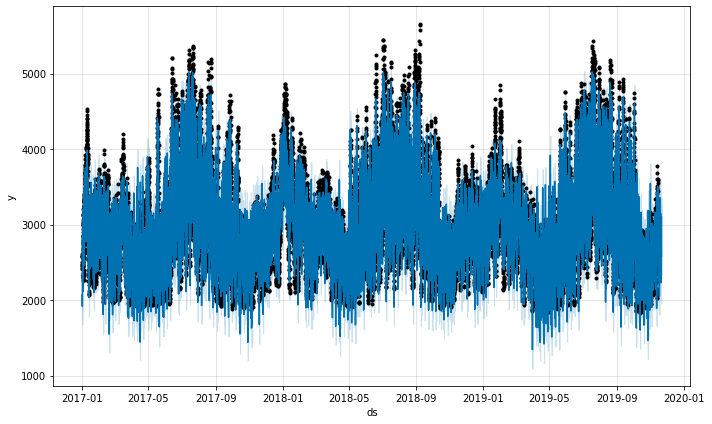

In [219]:
m.plot(forecast);

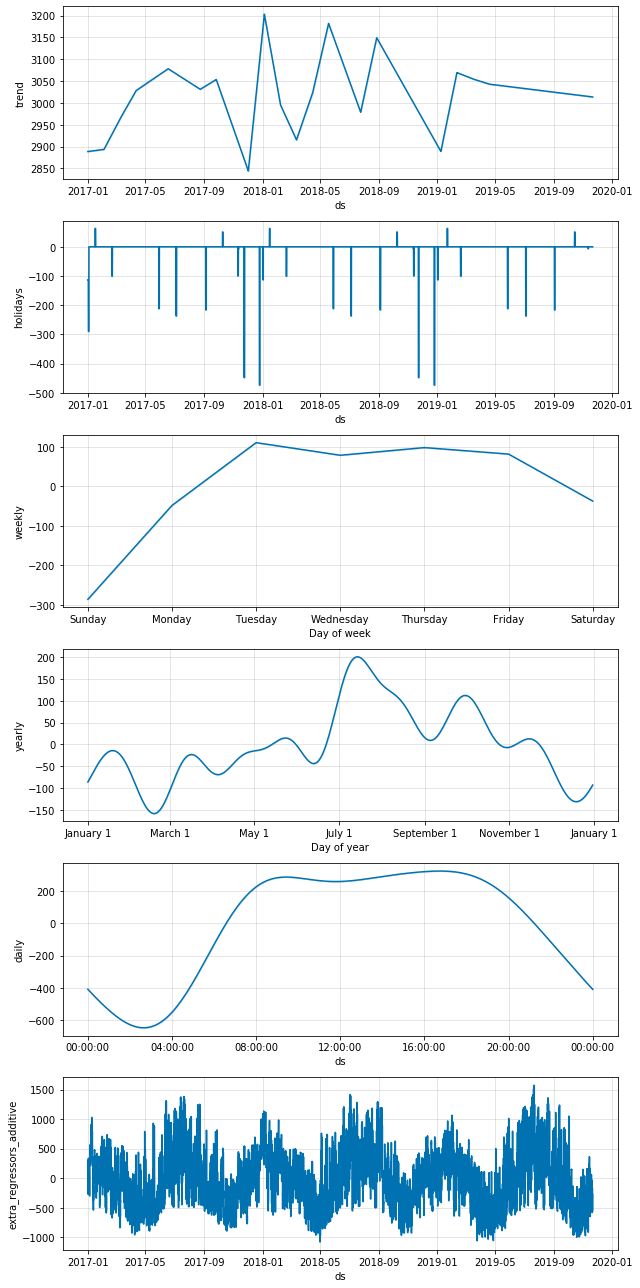

In [220]:
m.plot_components(forecast);

In [214]:
compare_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_mw.set_index('ds'))

In [215]:
mean_squared_error(y_true=compare_df['y'],
                   y_pred=compare_df['yhat'])

37583.991924244336

In [216]:
mean_absolute_error(y_true=compare_df['y'],
                   y_pred=compare_df['yhat'])

151.90439064782623

In [217]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=compare_df['y'],
                   y_pred=compare_df['yhat'])

5.251971062017102

In [ ]:
# adding box cox

In [14]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [15]:
df_mw_box = df_mw.copy()

In [16]:
df_mw_box['y'], lambda_prophet = stats.boxcox(df_mw_box['y'])

In [51]:
# 7-day prediction size (24 * 7 = 168)
prediction_size = 168
train_df_box = df_mw_box[:-prediction_size]

In [52]:
holidays = pd.DataFrame(columns=['ds', 'holiday'])
m_box = Prophet(holidays=holidays)
m_box.add_regressor('HDD')
m_box.add_regressor('CDD')
m_box.add_regressor('dewPoint')
m_box.add_regressor('sunniness')
m_box.add_regressor('total_outages_mw')
m_box.add_regressor('visibility')
m_box.add_regressor('apparentTemperature')
m_box.add_country_holidays(country_name='US')

In [53]:
m_box.fit(train_df_box)

In [54]:
future_box = df_mw_box.drop(columns=['y'])

In [55]:
forecast_box = m_box.predict(future_box)

In [57]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        forecast_box[column] = inverse_boxcox(forecast_box[column], lambda_prophet)
m_box.history['y'] = inverse_boxcox(m_box.history['y'], lambda_prophet)

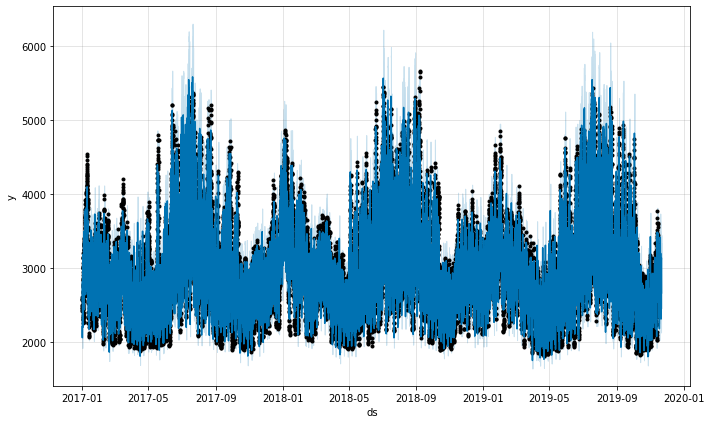

In [58]:
m_box.plot(forecast_box);

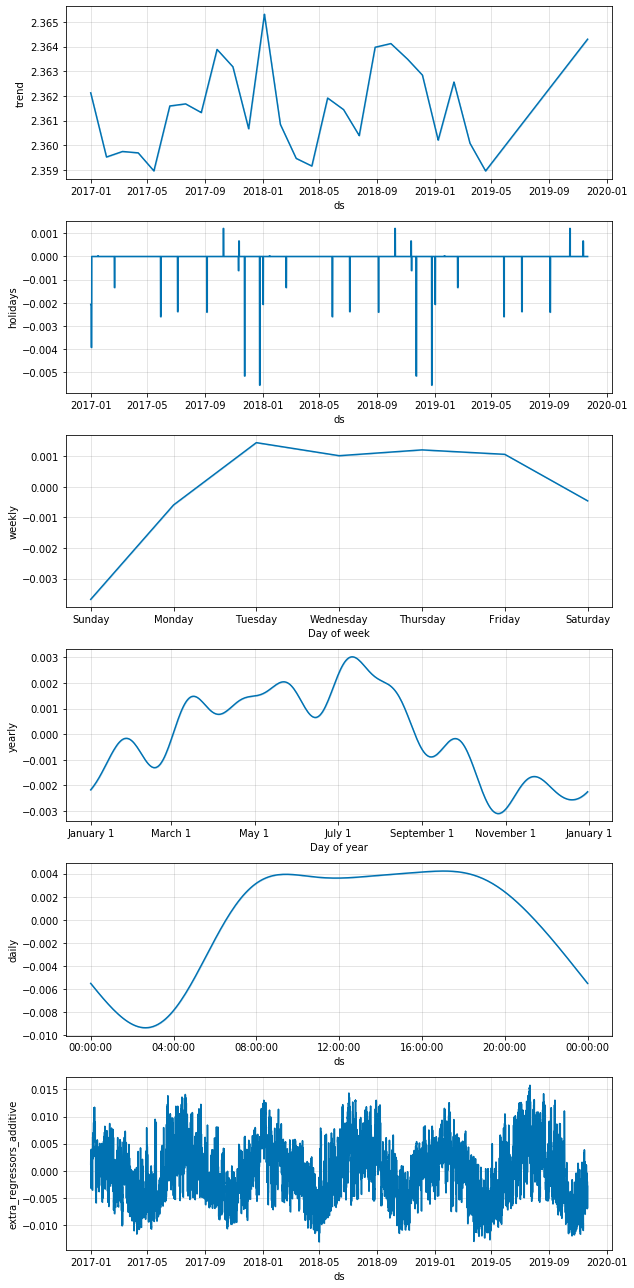

In [59]:
m_box.plot_components(forecast_box);

In [60]:
compare_df_box = forecast_box.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_mw.set_index('ds'))

In [61]:
mean_squared_error(y_true=compare_df_box['y'],
                   y_pred=compare_df_box['yhat'])

34892.28859985916

In [62]:
mean_absolute_error(y_true=compare_df_box['y'],
                   y_pred=compare_df_box['yhat'])

146.20057182596568

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=compare_df_box['y'],
                   y_pred=compare_df_box['yhat'])

4.979183970867707

In [ ]:
# no regressors

In [188]:
# 7-day prediction size (24 * 7 = 168)
prediction_size = 168
train_df = df_mw[:-prediction_size]

In [189]:
holidays = pd.DataFrame(columns=['ds', 'holiday'])
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')

In [190]:
m.fit(train_df)

In [191]:
# future = m.make_future_dataframe(periods=prediction_size)
# future = future.loc[future['ds'] < datetime(2019, 11, 14)]
# future.tail(20)

In [195]:
future = df_mw[['ds']]

In [197]:
forecast = m.predict(future)

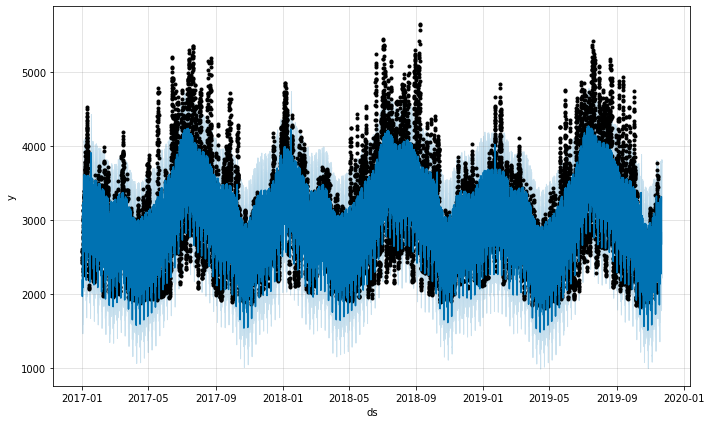

In [198]:
m.plot(forecast);

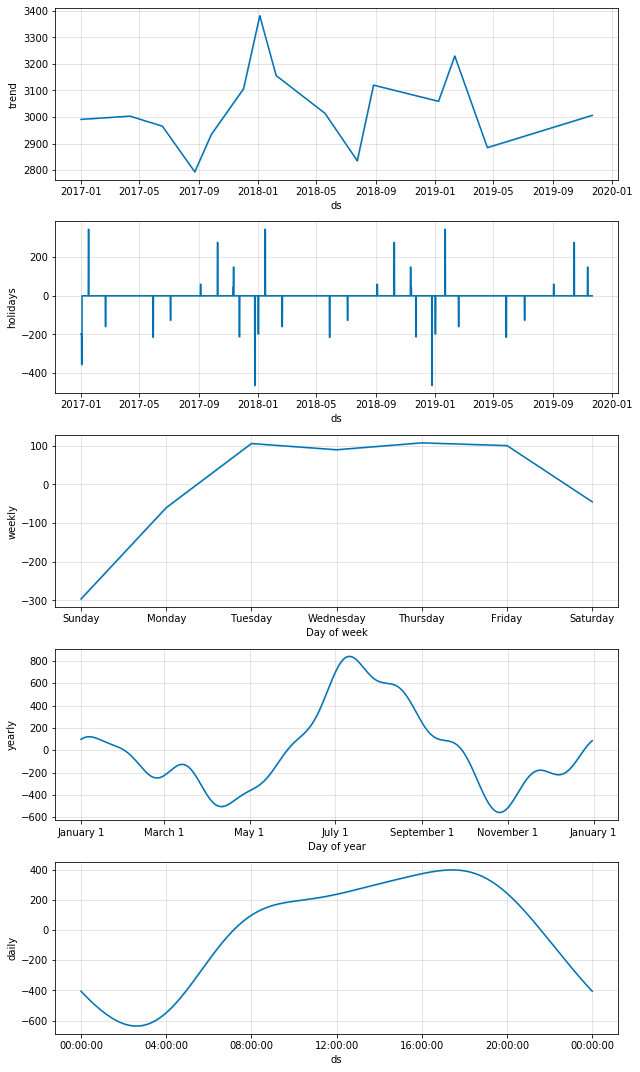

In [199]:
m.plot_components(forecast);

In [200]:
compare_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_mw.set_index('ds'))

In [201]:
mean_squared_error(y_true=compare_df['y'],
                   y_pred=compare_df['yhat'])

145245.86550269052

In [202]:
mean_absolute_error(y_true=compare_df['y'],
                   y_pred=compare_df['yhat'])

296.09866062773193

In [203]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=compare_df['y'],
                   y_pred=compare_df['yhat'])

9.739825480020661